## Model  with  3 conv layers with  16,32,64 filters resp

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


!unzip '/content/gdrive/MyDrive/2.zip'



import os
a = '/content/1/test/aeroplane'
path, dirs, files = next(os.walk(a))
file_count = len(files)
print(file_count)


import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])


train_data_dir = "/content/1/train"

val_data_dir = "/content/1/val"
test_data_dir = "/content/1/test"
# take the dataset from the location nad transform it 
trainset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
#divide the data into batches with batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)
print(len(trainset))

valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valnset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)




import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=1024, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=5)
         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
       
        
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()

########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion,net):
    running_loss = 0.0
    correct=0
    total=0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    print('Accuracy of the network on the train images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

    
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/bestmodelfilter16.pth')


In [ ]:
print(len(train_accuracies))
print(len(val_accuracies))
with open(r'trainfilter16.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)

50
50


In [ ]:
with open(r'valfilter16.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)

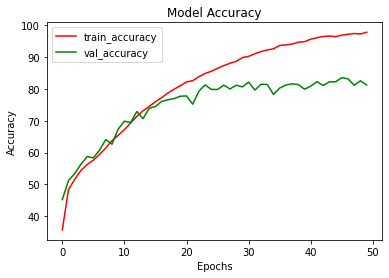

In [ ]:
epochs= np.arange(0, 50, 1)
  
# Assign variables to the y axis part of the curve
y = train_accuracies
z = val_accuracies
  
# Plotting both the curves simultaneously
plt.plot(epochs, y, color='r', label='train_accuracy')
plt.plot(epochs, z, color='g', label='val_accuracy')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

## Model with 3 conv layers with 256,512,1024 filters resp

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


!unzip '/content/gdrive/MyDrive/2.zip'



import os
a = '/content/1/test/aeroplane'
path, dirs, files = next(os.walk(a))
file_count = len(files)
print(file_count)


import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])


train_data_dir = "/content/1/train"

val_data_dir = "/content/1/val"
test_data_dir = "/content/1/test"
# take the dataset from the location nad transform it 
trainset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
#divide the data into batches with batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)
print(len(trainset))

valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valnset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)




import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=5)
        self.fc4= nn.Linear(in_features=128, out_features=5)

         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
       
        
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()

########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion,net):
    running_loss = 0.0
    correct=0
    total=0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    print('Accuracy of the network on the train images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

    
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/bestmodelfilter16.pth')


In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=5)
         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
       
        
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()
device_name = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
modl = Net().to(device_name)
summary(modl, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
         MaxPool2d-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 256, 32, 32]         147,712
         MaxPool2d-4          [-1, 256, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         590,080
         MaxPool2d-6            [-1, 256, 8, 8]               0
            Linear-7                  [-1, 256]          65,792
            Linear-8                  [-1, 128]          32,896
            Linear-9                    [-1, 5]             645
Total params: 838,917
Trainable params: 838,917
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 5.63
Params size (MB): 3.20
Estimated Total Size (MB): 8.88
-------------------------------------------